In [1]:
%load_ext autoreload

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s') # NOTSET, DEBUG, INFO, WARN, ERROR, CRITICAL

from JPAS_DA.data import data_loaders
from JPAS_DA.data import generate_toy_data
from JPAS_DA.models import model_building_tools
from JPAS_DA.training import training_tools
from JPAS_DA.training import save_load_tools
from JPAS_DA.evaluation import evaluation_tools

import os
import torch
import numpy as np

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from JPAS_DA.utils import plotting_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('default')
plt.close('all')
font, rcnew = plotting_utils.matplotlib_default_config()
mpl.rc('font', **font)
plt.rcParams.update(rcnew)
plt.style.use('tableau-colorblind10')
%matplotlib widget

from JPAS_DA.utils import aux_tools
aux_tools.set_seed(42)

/tmp/ipykernel_39234/550949071.py:48: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_dict = {cls: plt.cm.get_cmap("tab10")(i) for i, cls in enumerate(np.arange(n_classes))}


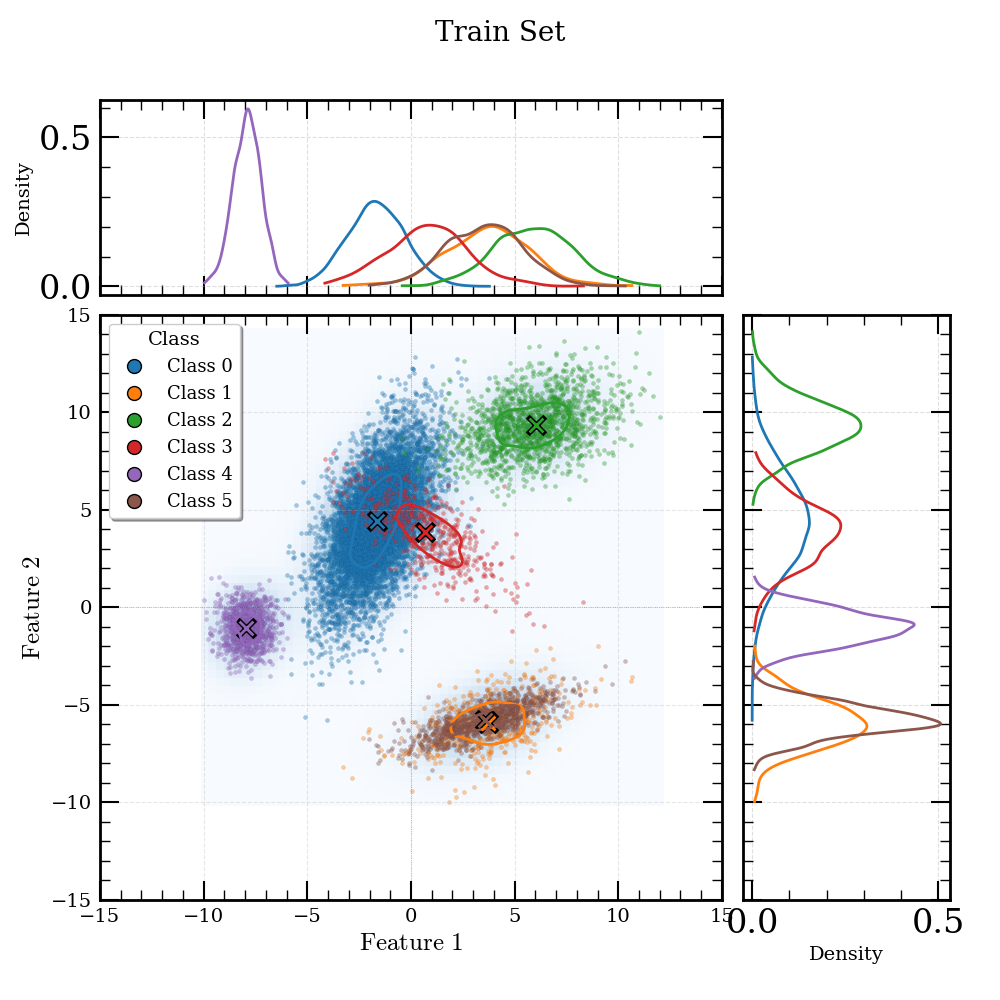

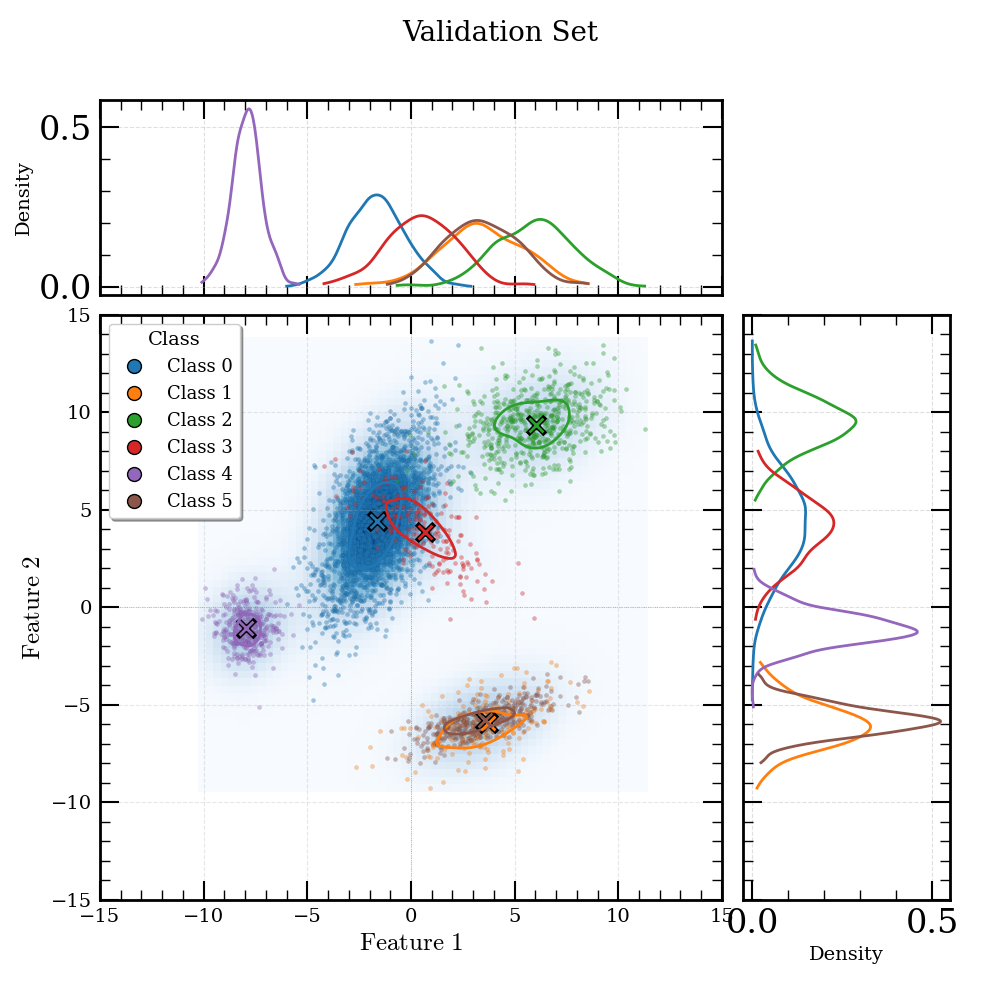

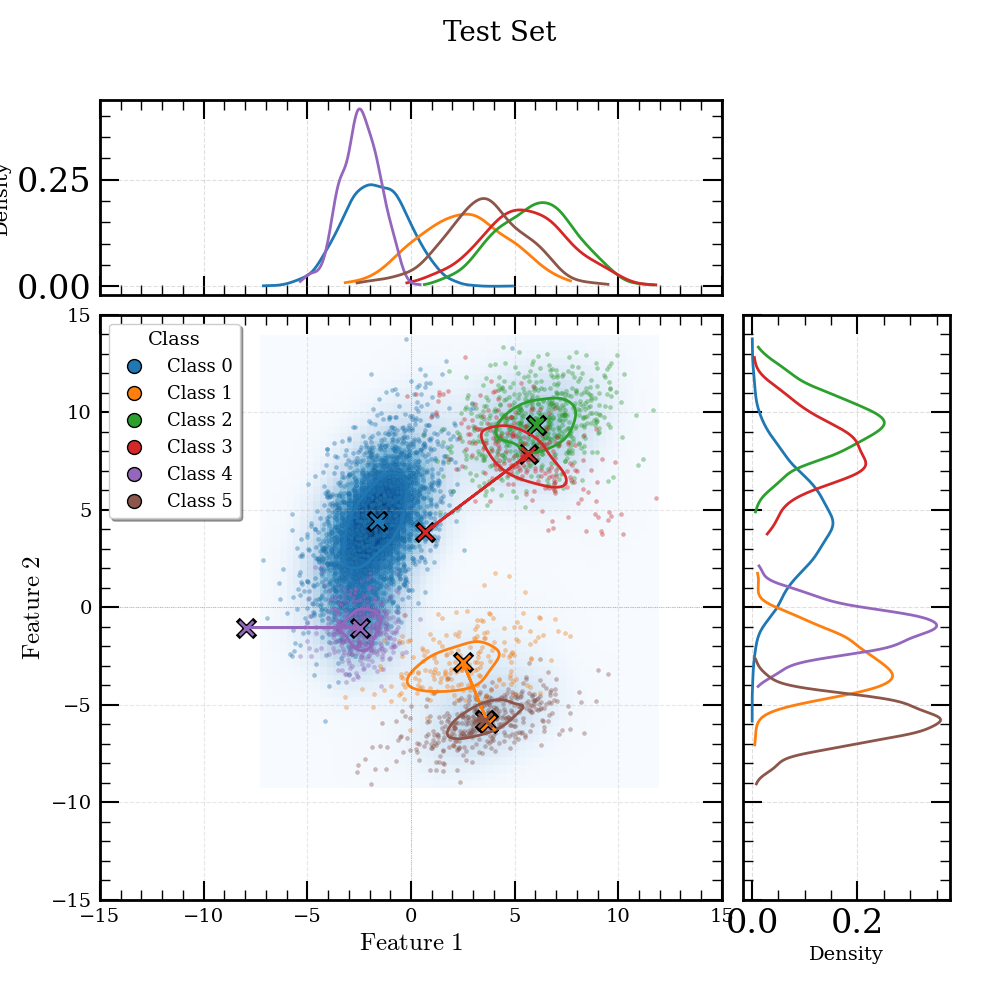

In [2]:
# === Shared Parameters ===
n_classes = 6
n_features = 2
class_center_range = [(-10, 10), (-10, 10)]
cov_scale_range = (0.1, 1.1)
class_proportions = np.array([0.55, 0.05, 0.15, 0.05, 0.1, 0.1])
assert np.isclose(class_proportions.sum(), 1.0)

# === Sample Sizes and Seeds ===
n_samples_train = 10000
n_samples_val = 4000
n_samples_test = 4000
n_samples_train_DA = 4000
n_samples_val_DA = 4000

seed_structure = 1     # Used to define centers and covariances
seed_train = 42        # Ensures different train/val/test samples
seed_val = 13
seed_test = 0
seed_train_DA = 2
seed_val_DA = 3
seed_shift = 4

# === Generate fixed shared structure for train/val ===
shared_centers, shared_covs = generate_toy_data.generate_centers_covs(n_classes, n_features, class_center_range, cov_scale_range, seed_structure)

# === Generate train/val sets with different seeds but same structure ===
xx_train, yy_train, train_counts = generate_toy_data.generate_dataset_from_structure(n_samples_train, shared_centers, shared_covs, class_proportions, seed=seed_train)
xx_val, yy_val, val_counts = generate_toy_data.generate_dataset_from_structure(n_samples_val, shared_centers, shared_covs, class_proportions, seed=seed_val)

# === Generate test set with shifted centers and covs ===
shifted_centers, shifted_covs = generate_toy_data.shift_centers_covs(shared_centers, shared_covs, center_shift=1.0, cov_shift=0.5, seed=seed_shift)

shifted_centers = np.array([
[-1.65955991,  4.40648987],
[ 2.50439001, -2.81095501],
[ 6.01489137,  9.36523151],
[ 5.6633057 ,  7.83754228],
[-2.43547987, -1.04212948],
[ 3.57671066, -5.76743768]
])
xx_test, yy_test, test_counts = generate_toy_data.generate_dataset_from_structure(n_samples_test, shifted_centers, shifted_covs, class_proportions, seed=seed_test)
xx_train_DA, yy_train_DA, _ = generate_toy_data.generate_dataset_from_structure(n_samples_val_DA, shifted_centers, shifted_covs, class_proportions, seed=seed_val_DA)
xx_val_DA, yy_val_DA, _ = generate_toy_data.generate_dataset_from_structure(n_samples_val_DA, shifted_centers, shifted_covs, class_proportions, seed=seed_val_DA)


# === Visualize sets ===
color_dict = {cls: plt.cm.get_cmap("tab10")(i) for i, cls in enumerate(np.arange(n_classes))}

fig1, ax_main1 = plotting_utils.plot_2d_classification_with_kde(xx_train["OBS"], yy_train["SPECTYPE_int"], title="Train Set", class_color_dict=color_dict)
for i in range(n_classes):
    ax_main1.scatter(shared_centers[i, 0], shared_centers[i, 1], marker="x", color='black', s=160, linewidth=4, zorder=1)
    ax_main1.scatter(shared_centers[i, 0], shared_centers[i, 1], marker="x", color=color_dict[i], s=100, linewidth=2, zorder=2)
ax_main1.set_xlim(-15, 15)
ax_main1.set_ylim(-15, 15)
plt.show()

fig2, ax_main2 = plotting_utils.plot_2d_classification_with_kde(xx_val["OBS"], yy_val["SPECTYPE_int"], title="Validation Set", class_color_dict=color_dict)
for i in range(n_classes):
    ax_main2.scatter(shared_centers[i, 0], shared_centers[i, 1], marker="x", color='black', s=160, linewidth=4, zorder=1)
    ax_main2.scatter(shared_centers[i, 0], shared_centers[i, 1], marker="x", color=color_dict[i], s=100, linewidth=2, zorder=2)
ax_main2.set_xlim(-15, 15)
ax_main2.set_ylim(-15, 15)
plt.show()

fig3, ax_main3 = plotting_utils.plot_2d_classification_with_kde(xx_test["OBS"], yy_test["SPECTYPE_int"], title="Test Set", class_color_dict=color_dict)
for i in range(n_classes):
    ax_main3.scatter(shared_centers[i, 0], shared_centers[i, 1], marker="x", color='black', s=160, linewidth=4, zorder=1)
    ax_main3.scatter(shared_centers[i, 0], shared_centers[i, 1], marker="x", color=color_dict[i], s=100, linewidth=2, zorder=2)
for i in range(n_classes):
    ax_main3.scatter(shifted_centers[i, 0], shifted_centers[i, 1], marker="x", color='black', s=160, linewidth=4, zorder=1)
    ax_main3.scatter(shifted_centers[i, 0], shifted_centers[i, 1], marker="x", color=color_dict[i], s=100, linewidth=2, zorder=2)
for i in range(n_classes):
    delta = shifted_centers[i] - shared_centers[i]
    ax_main3.arrow(shared_centers[i, 0], shared_centers[i, 1], delta[0], delta[1], color=color_dict[i], linewidth=2, head_width=0.2, length_includes_head=True)
ax_main3.set_xlim(-15, 15)
ax_main3.set_ylim(-15, 15)
plt.show()

In [3]:
path_load_no_DA = "/home/dlopez/Documents/Projects/JPAS_Domain_Adaptation/SAVED_models/06_example_model"
path_load_DA = "/home/dlopez/Documents/Projects/JPAS_Domain_Adaptation/SAVED_models/07_example_model_DA"

In [4]:
means, stds = save_load_tools.load_means_stds(path_load_no_DA)
means_DA, stds_DA = save_load_tools.load_means_stds(path_load_no_DA)
evaluation_tools.assert_array_lists_equal(means, means_DA)
evaluation_tools.assert_array_lists_equal(stds, stds_DA)

dset_val_no_DA = data_loaders.DataLoader(xx_val, yy_val, normalize=True, provided_normalization=(means, stds))
dset_val_DA = data_loaders.DataLoader(xx_val_DA, yy_val_DA, normalize=True, provided_normalization=(means, stds))
dset_test = data_loaders.DataLoader(xx_test, yy_test, normalize=True, provided_normalization=(means, stds))

2025-05-17 15:19:08,512 - INFO - 🎉 All arrays match.
2025-05-17 15:19:08,513 - INFO - 🎉 All arrays match.
2025-05-17 15:19:08,513 - INFO - ├── 💿 Initializing DataLoader object with 4000 samples...
2025-05-17 15:19:08,513 - INFO - ├── ✔ Finished Initialization. Class distribution: [0: 2200 (55.00%), 1: 200 (5.00%), 2: 600 (15.00%), 3: 200 (5.00%), 4: 400 (10.00%), 5: 400 (10.00%)]
2025-05-17 15:19:08,513 - INFO - ├── 💿 Initializing DataLoader object with 4000 samples...
2025-05-17 15:19:08,514 - INFO - ├── ✔ Finished Initialization. Class distribution: [0: 2200 (55.00%), 1: 200 (5.00%), 2: 600 (15.00%), 3: 200 (5.00%), 4: 400 (10.00%), 5: 400 (10.00%)]
2025-05-17 15:19:08,514 - INFO - ├── 💿 Initializing DataLoader object with 4000 samples...
2025-05-17 15:19:08,514 - INFO - ├── ✔ Finished Initialization. Class distribution: [0: 2200 (55.00%), 1: 200 (5.00%), 2: 600 (15.00%), 3: 200 (5.00%), 4: 400 (10.00%), 5: 400 (10.00%)]


In [5]:
_, model_encoder_no_DA = save_load_tools.load_model_from_checkpoint(os.path.join(path_load_no_DA, "model_encoder.pt"), model_building_tools.create_mlp)
_, model_downstream_no_DA = save_load_tools.load_model_from_checkpoint(os.path.join(path_load_no_DA, "model_downstream.pt"), model_building_tools.create_mlp)

_, model_encoder_DA = save_load_tools.load_model_from_checkpoint(os.path.join(path_load_DA, "model_encoder.pt"), model_building_tools.create_mlp)
_, model_downstream_DA = save_load_tools.load_model_from_checkpoint(os.path.join(path_load_DA, "model_downstream.pt"), model_building_tools.create_mlp)

_ = evaluation_tools.compare_model_parameters(model_downstream_no_DA, model_downstream_DA, rtol=1e-2, atol=1e-2)

✅ All parameters match.


/home/dlopez/Documents/Projects/JPAS_Domain_Adaptation/JPAS_DA/training/save_load_tools.py:46: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path_che

In [6]:
xx, yy_true = dset_val_no_DA(batch_size=dset_val_no_DA.NN_xx, seed=0, sampling_strategy="true_random", to_torch=True, device="cpu")
with torch.no_grad():
        features_ = model_encoder_no_DA(xx)
        logits = model_downstream_no_DA(features_)
yy_pred_P = torch.nn.functional.softmax(logits, dim=1)

yy_true_val_no_DA = yy_true.cpu().numpy()
features_val_no_DA = features_.cpu().numpy()
yy_pred_P_val_no_DA = yy_pred_P.cpu().numpy()
yy_pred_val_no_DA = np.argmax(yy_pred_P_val_no_DA, axis=1)


xx, yy_true = dset_val_DA(batch_size=dset_val_DA.NN_xx, seed=0, sampling_strategy="true_random", to_torch=True, device="cpu")
with torch.no_grad():
        features_ = model_encoder_DA(xx)
        logits = model_downstream_DA(features_)
yy_pred_P = torch.nn.functional.softmax(logits, dim=1)

yy_true_val_DA = yy_true.cpu().numpy()
features_val_DA = features_.cpu().numpy()
yy_pred_P_val_DA = yy_pred_P.cpu().numpy()
yy_pred_val_DA = np.argmax(yy_pred_P_val_DA, axis=1)


xx, yy_true = dset_test(batch_size=dset_test.NN_xx, seed=0, sampling_strategy="true_random", to_torch=True, device="cpu")
with torch.no_grad():
        features_ = model_encoder_no_DA(xx)
        logits = model_downstream_no_DA(features_)
yy_pred_P = torch.nn.functional.softmax(logits, dim=1)

yy_true_test = yy_true.cpu().numpy()
features_test_no_DA = features_.cpu().numpy()
yy_pred_P_test_no_DA = yy_pred_P.cpu().numpy()
yy_pred_test_no_DA = np.argmax(yy_pred_P_test_no_DA, axis=1)


xx, yy_true = dset_test(batch_size=dset_test.NN_xx, seed=0, sampling_strategy="true_random", to_torch=True, device="cpu")
with torch.no_grad():
        features_ = model_encoder_DA(xx)
        logits = model_downstream_DA(features_)
yy_pred_P = torch.nn.functional.softmax(logits, dim=1)

yy_true_test = yy_true.cpu().numpy()
features_test_DA = features_.cpu().numpy()
yy_pred_P_test_DA = yy_pred_P.cpu().numpy()
yy_pred_test_DA = np.argmax(yy_pred_P_test_DA, axis=1)

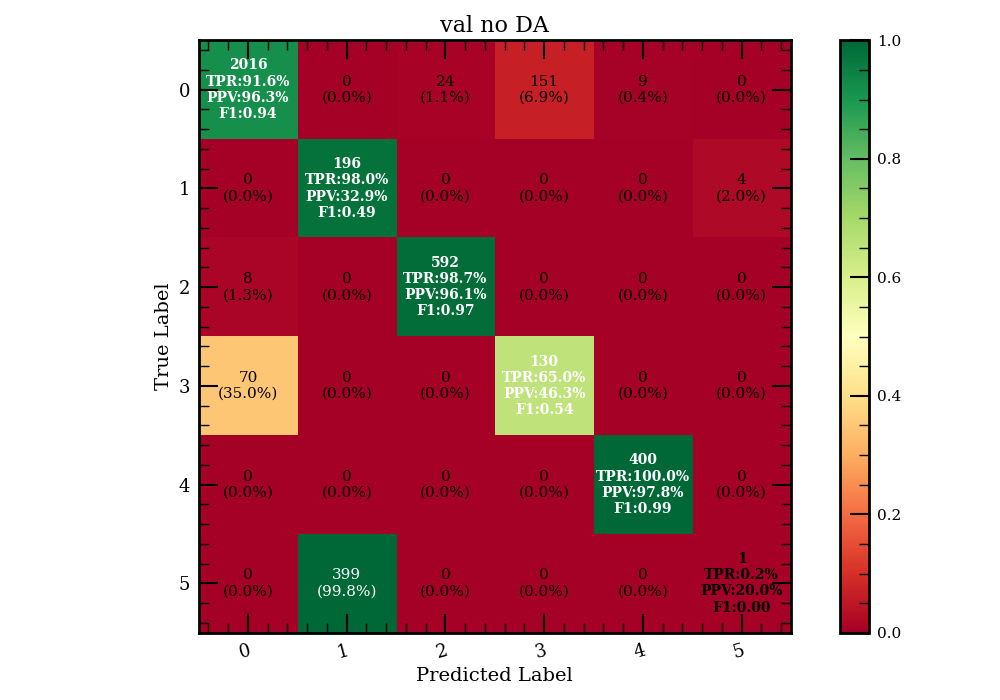

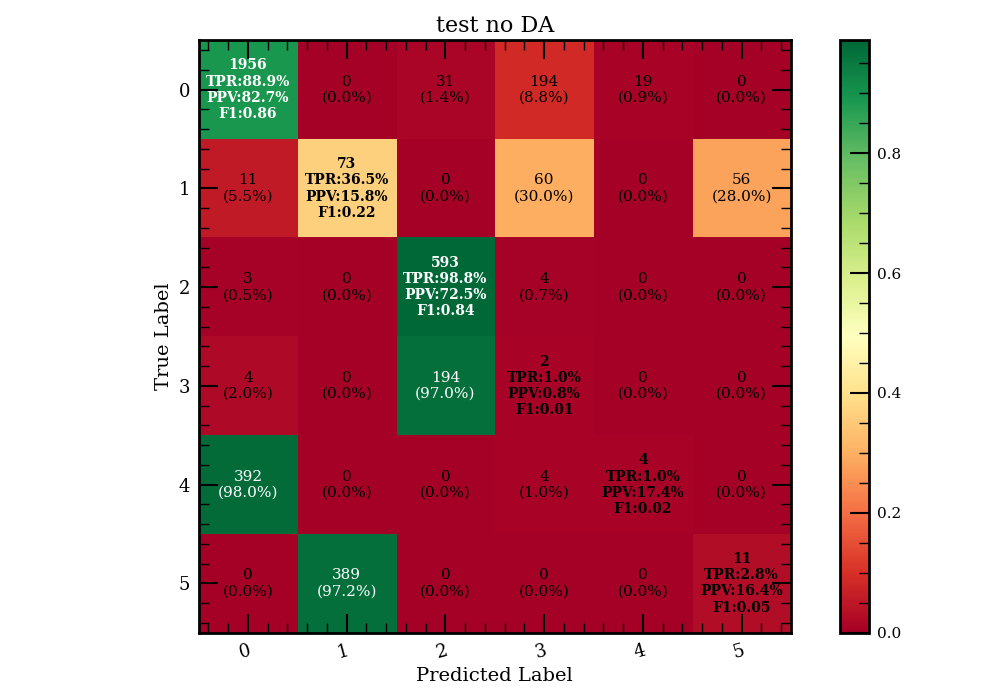

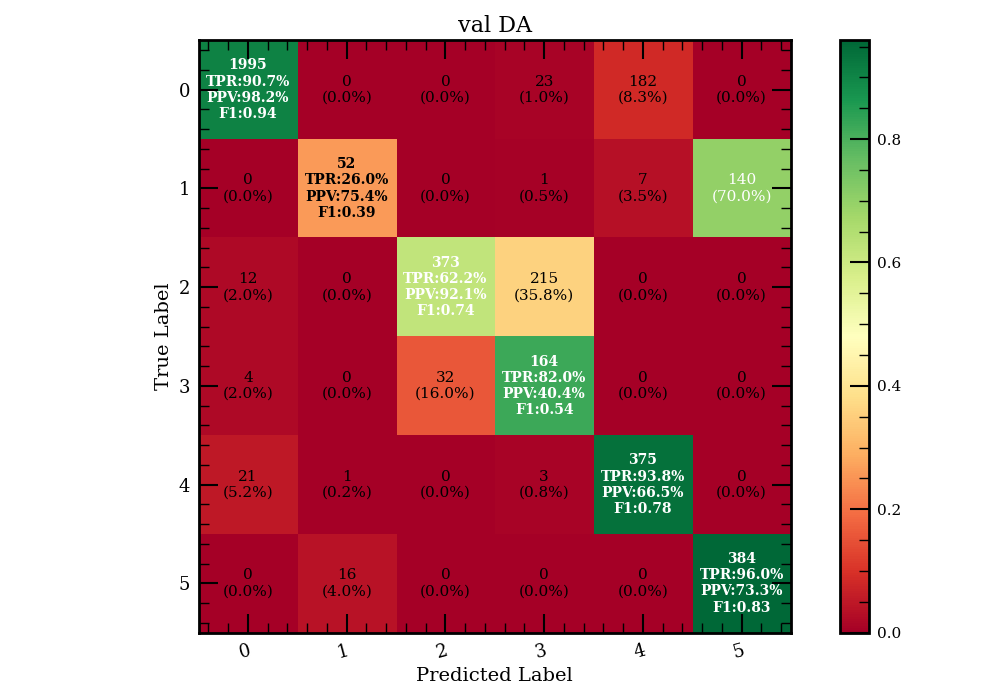

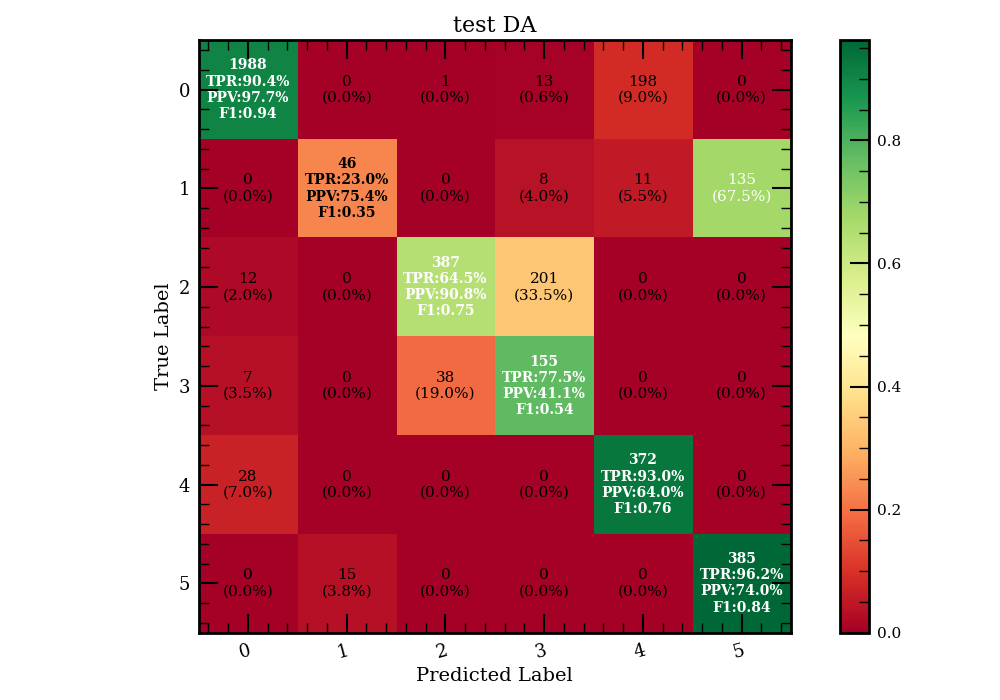

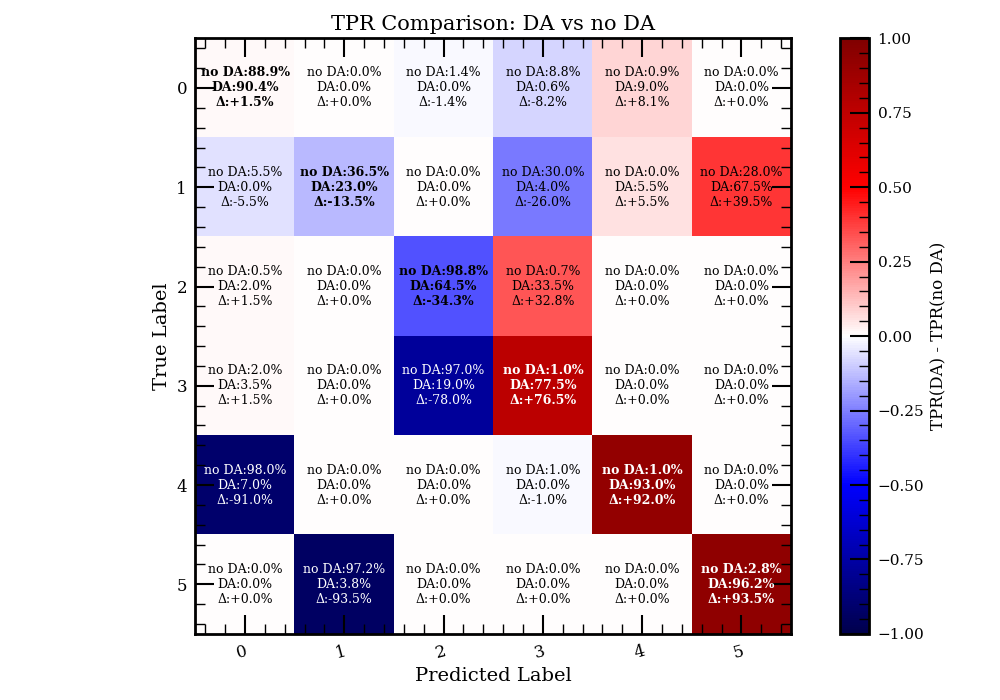

In [7]:
plotting_utils.plot_confusion_matrix(
    yy_true_val_no_DA, yy_pred_P_val_no_DA,
    class_names=np.arange(n_classes),
    cmap=plt.cm.RdYlGn, title="val no DA"
)

plotting_utils.plot_confusion_matrix(
    yy_true_test, yy_pred_P_test_no_DA,
    class_names=np.arange(n_classes),
    cmap=plt.cm.RdYlGn, title="test no DA"
)

plotting_utils.plot_confusion_matrix(
    yy_true_val_DA, yy_pred_P_val_DA,
    class_names=np.arange(n_classes),
    cmap=plt.cm.RdYlGn, title="val DA"
)

plotting_utils.plot_confusion_matrix(
    yy_true_test, yy_pred_P_test_DA,
    class_names=np.arange(n_classes),
    cmap=plt.cm.RdYlGn, title="test DA"
)

plotting_utils.compare_TPR_confusion_matrices(
    yy_true_test,
    yy_pred_P_test_no_DA,
    yy_true_test,
    yy_pred_P_test_DA,
    class_names=np.arange(n_classes),
    figsize=(10, 7),
    cmap='seismic',
    title='TPR Comparison: DA vs no DA',
    name_1 = "no DA",
    name_2 = "DA"
)


=== no DA vs DA Metrics ===
Metric                     no DA          DA    Δ (DA - no DA)
--------------------------------------------------------------
Accuracy                  0.6597      0.8333            0.1735
Macro F1                  0.3314      0.6964            0.3650
Macro TPR                 0.3817      0.7410            0.3594
Macro Precision           0.3426      0.7385            0.3960
Macro AUROC               0.7636      0.9663            0.2027
ECE                       0.2722      0.0578           -0.2144


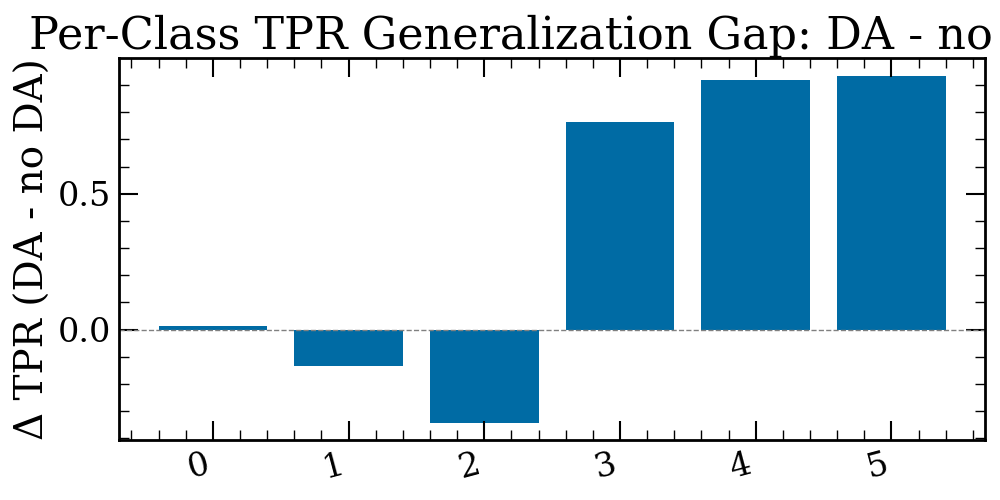

In [8]:
plotting_utils.compare_sets_performance(
    yy_true_test, yy_pred_P_test_no_DA,
    yy_true_test, yy_pred_P_test_DA,
    class_names=np.arange(n_classes),
    name_1="no DA",
    name_2="DA",
)

In [9]:
from sklearn.manifold import TSNE

# === Stack all feature representations together ===
X_all = np.vstack([
    features_val_no_DA,
    features_val_DA,
    features_test_no_DA,
    features_test_DA
])

# === Perform shared t-SNE projection ===
tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=42)
X_all_tsne = tsne.fit_transform(X_all)

# === Split back to original domains ===
n_val = features_val_no_DA.shape[0]
n_test = features_test_no_DA.shape[0]

X_val_no_DA_tsne   = X_all_tsne[0:n_val]
X_val_DA_tsne      = X_all_tsne[n_val:2*n_val]
X_test_no_DA_tsne  = X_all_tsne[2*n_val:2*n_val + n_test]
X_test_DA_tsne     = X_all_tsne[2*n_val + n_test:]

/tmp/ipykernel_39234/1595444245.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab10")


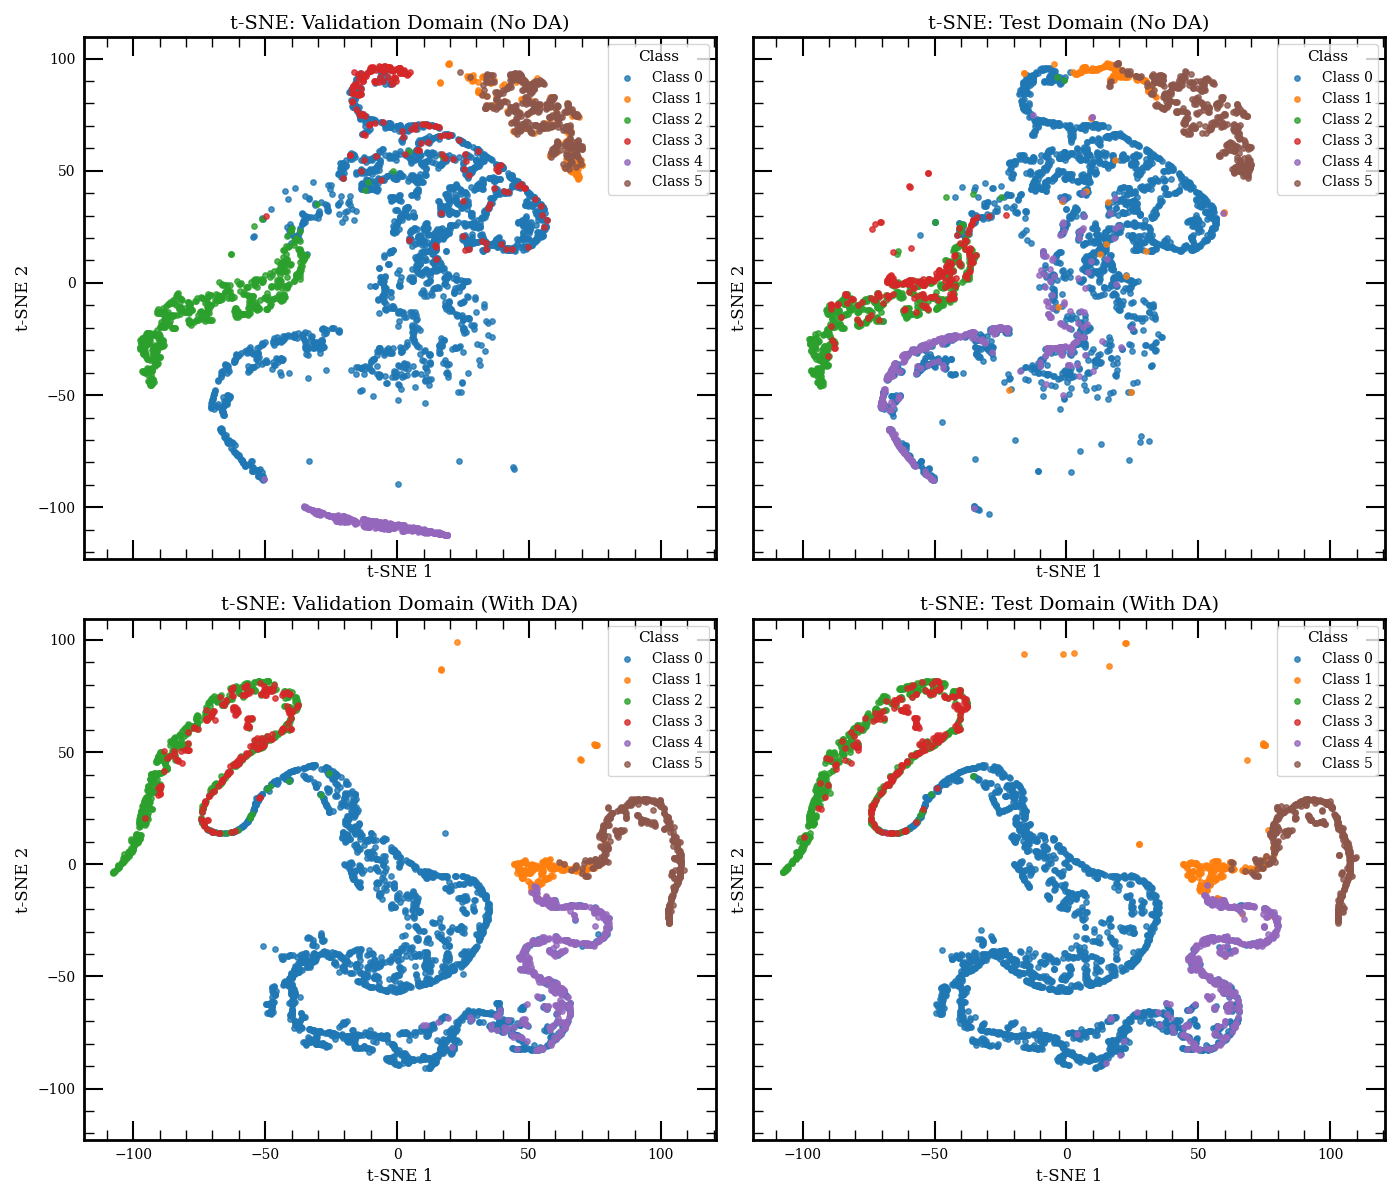

In [10]:
# === Use consistent labels and colors ===
y_all = np.concatenate([yy_true_val_no_DA, yy_true_val_DA, yy_true_test, yy_true_test])
unique_classes = np.unique(y_all)
cmap = plt.cm.get_cmap("tab10")
class_color_dict = {cls: cmap(i) for i, cls in enumerate(unique_classes)}

# === Setup 2×2 plot ===
fig, axs = plt.subplots(2, 2, figsize=(14, 12), sharex=True, sharey=True)
titles = [
    "t-SNE: Validation Domain (No DA)",
    "t-SNE: Test Domain (No DA)",
    "t-SNE: Validation Domain (With DA)",
    "t-SNE: Test Domain (With DA)"
]
datasets = [
    (X_val_no_DA_tsne, yy_true_val_no_DA, axs[0, 0]),
    (X_test_no_DA_tsne, yy_true_test, axs[0, 1]),
    (X_val_DA_tsne, yy_true_val_DA, axs[1, 0]),
    (X_test_DA_tsne, yy_true_test, axs[1, 1])
]

# === Plot each case ===
for (X_emb, y_labels, ax), title in zip(datasets, titles):
    for cls in unique_classes:
        idx = y_labels == cls
        ax.scatter(X_emb[idx, 0], X_emb[idx, 1],
                   color=class_color_dict[cls], label=f"Class {cls}",
                   s=15, alpha=0.8)
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("t-SNE 1", fontsize=12)
    ax.set_ylabel("t-SNE 2", fontsize=12)
    ax.tick_params(labelsize=10)
    ax.legend(title="Class", fontsize=10, title_fontsize=11)

plt.tight_layout()
plt.show()

In [11]:
# === Generate meshgrid from training data bounds ===
x_min, x_max = -15, 15
y_min, y_max = -15, 15

grid_res = 256
xx_vals = np.linspace(x_min, x_max, grid_res)
yy_vals = np.linspace(y_min, y_max, grid_res)
xx_mesh, yy_mesh = np.meshgrid(xx_vals, yy_vals)

grid_points = np.stack([xx_mesh.ravel(), yy_mesh.ravel()], axis=1)
grid_points = (grid_points - means[0]) / stds[0]
xx_grid = torch.tensor(grid_points, dtype=torch.float32, device="cpu")


with torch.no_grad():
        features_ = model_encoder_no_DA(xx_grid)
        logits = model_downstream_no_DA(features_)
yy_pred_P = torch.nn.functional.softmax(logits, dim=1)

features_grid_no_DA = features_.cpu().numpy()
yy_pred_P_grid_no_DA = yy_pred_P.cpu().numpy()
yy_pred_grid_no_DA = np.argmax(yy_pred_P_grid_no_DA, axis=1)


with torch.no_grad():
        features_ = model_encoder_DA(xx_grid)
        logits = model_downstream_DA(features_)
yy_pred_P = torch.nn.functional.softmax(logits, dim=1)

features_grid_DA = features_.cpu().numpy()
yy_pred_P_grid_DA = yy_pred_P.cpu().numpy()
yy_pred_grid_DA = np.argmax(yy_pred_P_grid_DA, axis=1)

/tmp/ipykernel_39234/2790800859.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_base = plt.cm.get_cmap("tab10")


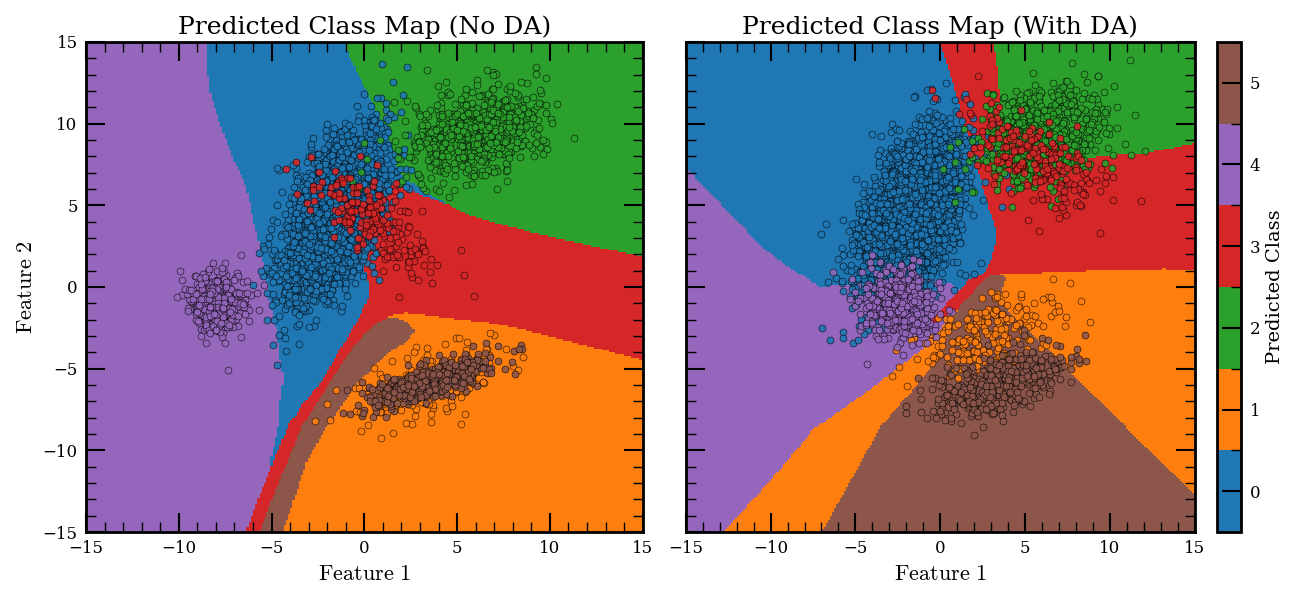

In [12]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

# === Prepare prediction grids ===
Z_no_DA = yy_pred_grid_no_DA.reshape(grid_res, grid_res).astype(float)
Z_DA    = yy_pred_grid_DA.reshape(grid_res, grid_res).astype(float)

# === Class colormap ===
unique_labels = np.unique(np.concatenate([Z_no_DA, Z_DA]).astype(int))
cmap_base = plt.cm.get_cmap("tab10")
class_color_dict = {label: cmap_base(label) for label in unique_labels}
colors = [class_color_dict[label] for label in unique_labels]
cmap = mpl.colors.ListedColormap(colors)
boundaries = np.arange(len(unique_labels) + 1) - 0.5
norm = mpl.colors.BoundaryNorm(boundaries, ncolors=len(unique_labels))

# === Setup figure with two subplots ===
fig, (ax_no_DA, ax_DA) = plt.subplots(1, 2, figsize=(13, 6), sharex=True, sharey=True)

# === Plot No DA ===
pcm = ax_no_DA.pcolormesh(xx_mesh, yy_mesh, Z_no_DA, cmap=cmap, norm=norm, shading='nearest')
for label in unique_labels:
    mask = dset_val_no_DA.yy["SPECTYPE_int"] == label
    tmp = (dset_val_no_DA.xx["OBS"][mask] * stds[0]) + means[0]
    ax_no_DA.scatter(tmp[:, 0], tmp[:, 1], s=25, alpha=0.9,
                     color=class_color_dict[label], edgecolor='black', linewidth=0.4)
ax_no_DA.set_title("Predicted Class Map (No DA)", fontsize=18)
ax_no_DA.set_xlabel(r"$\mathrm{Feature~1}$", fontsize=16)
ax_no_DA.set_ylabel(r"$\mathrm{Feature~2}$", fontsize=16)
ax_no_DA.tick_params(labelsize=12)
ax_no_DA.set_xlim(x_min, x_max)
ax_no_DA.set_ylim(y_min, y_max)

# === Plot With DA ===
pcm = ax_DA.pcolormesh(xx_mesh, yy_mesh, Z_DA, cmap=cmap, norm=norm, shading='nearest')
for label in unique_labels:
    mask = dset_val_DA.yy["SPECTYPE_int"] == label
    tmp = (dset_val_DA.xx["OBS"][mask] * stds[0]) + means[0]
    ax_DA.scatter(tmp[:, 0], tmp[:, 1], s=25, alpha=0.9,
                  color=class_color_dict[label], edgecolor='black', linewidth=0.4)
ax_DA.set_title("Predicted Class Map (With DA)", fontsize=18)
ax_DA.set_xlabel(r"$\mathrm{Feature~1}$", fontsize=16)
ax_DA.tick_params(labelsize=12)
ax_DA.set_xlim(x_min, x_max)
ax_DA.set_ylim(y_min, y_max)

# === Shared colorbar ===
cbar = fig.colorbar(pcm, ax=ax_DA, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label("Predicted Class", fontsize=14)
cbar.ax.tick_params(labelsize=12)
cbar.set_ticks(np.arange(len(unique_labels)))
cbar.set_ticklabels(unique_labels)

plt.tight_layout()
plt.show()

In [13]:
from sklearn.manifold import TSNE

# === Stack all feature representations together ===
X_all = np.vstack([
    features_grid_no_DA,
    features_grid_DA
])

# === Perform shared t-SNE projection ===
tsne = TSNE(n_components=2, perplexity=30, init='pca', random_state=42)
X_all_tsne = tsne.fit_transform(X_all)

# === Split back to original domains ===
n_no_DA = features_grid_no_DA.shape[0]
n_DA = features_grid_DA.shape[0]

X_no_DA_tsne   = X_all_tsne[0:n_no_DA]
X_DA_tsne      = X_all_tsne[n_no_DA:2*n_DA]

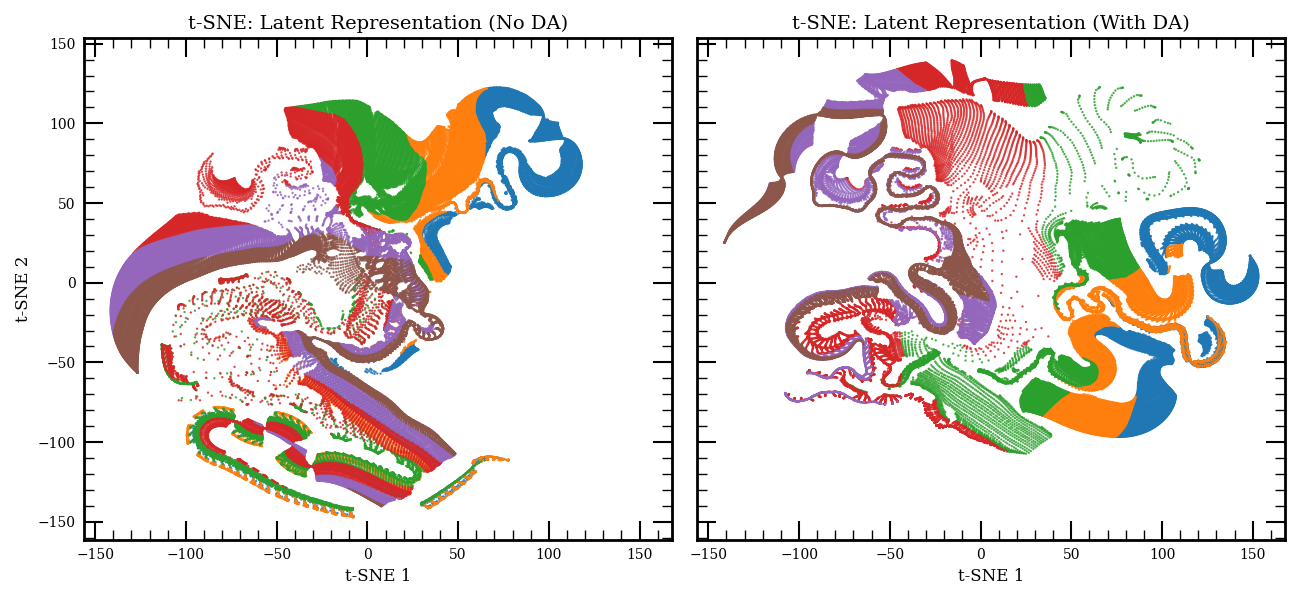

In [14]:
# === Split joint t-SNE embedding ===
X_no_DA_tsne = X_all_tsne[0:n_no_DA]
X_DA_tsne = X_all_tsne[n_no_DA:n_no_DA + n_DA]

# === Setup 1×2 plot ===
fig, (ax_no_DA, ax_DA) = plt.subplots(1, 2, figsize=(13, 6), sharex=True, sharey=True)

# Plot No DA
norm_no_DA = plt.Normalize(0, len(X_no_DA_tsne))
sc1 = ax_no_DA.scatter(X_no_DA_tsne[:, 0], X_no_DA_tsne[:, 1], c=np.arange(len(X_no_DA_tsne)), cmap=cmap, norm=norm_no_DA, s=0.5, alpha=0.8)
ax_no_DA.set_title("t-SNE: Latent Representation (No DA)", fontsize=14)
ax_no_DA.set_xlabel("t-SNE 1", fontsize=12)
ax_no_DA.set_ylabel("t-SNE 2", fontsize=12)
ax_no_DA.tick_params(labelsize=10)

# Plot With DA
norm_DA = plt.Normalize(0, len(X_DA_tsne))
sc2 = ax_DA.scatter(X_DA_tsne[:, 0], X_DA_tsne[:, 1], c=np.arange(len(X_DA_tsne)), cmap=cmap, norm=norm_no_DA, s=0.5, alpha=0.8)
ax_DA.set_title("t-SNE: Latent Representation (With DA)", fontsize=14)
ax_DA.set_xlabel("t-SNE 1", fontsize=12)
ax_DA.tick_params(labelsize=10)

plt.tight_layout()
plt.show()